## Neural Networks 101

Me: Mom can we have _nueral network_ at home? \
Mom: We have _neural network_ at home \
\*Nural network at home:

<img src="nnDiagram.jpeg" style="max-width: 400px; float: left;">
<p style="float: left; padding-top: 90px; width: 300px; padding-left: 60px">The code will be based on the above network, though will hopefully apply to any network</p>

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

__Sigmoid Function:__ 

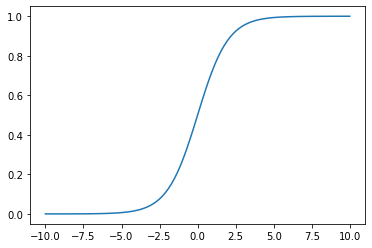

In [2]:
##
# define sigmoid function
# @param x vector of points
# @return sigmoid 1/(1+e^(-x))
# @return derivative of the sigmoid at that x
def sigmoid(x):
    sigmoid = np.divide(1, 1 + np.exp(-x))
    return sigmoid, np.multiply(sigmoid, (1 - sigmoid))


x = np.linspace(-10, 10, 100)


plt.plot(x, sigmoid(x)[0])
plt.show()

__Define binary cross entropy__: \
Function definition: _binaryCrossEntropy(x, t, W, alpha, networkSize)_ 
<p></p>
For the network visualized above, each parameter will look as follows: 


x = 
$[[x_{1, 1}, x_{2, 1}, x_{3, 1}], \\
[x_{1, 2}, x_{2, 2}, x_{3, 2}], \\
..., \\
[x_{1, N}, x_{2, N}, x_{3, N}]]\\
$
<hr>
t = 
$ [t_{1}, t_{2}, ... , t_{N}] $
<hr>
W = 
$
[w_{1, 0}^1, w_{1, 1}^1, w_{1, 2}^1, w_{1, 3}^1, \\
w_{2, 0}^1, w_{2, 1}^1, w_{2, 2}^1, w_{2, 3}^1, \\
w_{3, 0}^1, w_{3, 1}^1, w_{3, 2}^1, w_{3, 3}^1, \\
w_{1, 0}^2, w_{1, 1}^2, w_{1, 1}^2, w_{1, 1}^2] \\
$
<hr>
alpha = 
$ \alpha $
<hr>
network_size = $ [3, 1] $

In [31]:
# returns loss value and gradient
# inputs: training point x and targets t
#         initial weight vector
#         alpha is the regularization parameter
#         network_size, network_size(k) = num neurons in layer k
#
# return: value of binary cross entropy loss
#         value of gradient
def binaryCrossEntropy(X, T, W, alpha, networkSize):
    for index in range(len(X)):
        x = X[index].reshape(-1, 1)
        t = T[index]
        # define important vallues
        previousLayer = x
        currLayer = 1
        preactivation = np.zeros((1, sum(networkSize[1:]))).T
        postactivation = np.zeros((1, sum(networkSize[1:]))).T
        startIndexW = 0
        endIndexW = startIndexW + (len(previousLayer) + 1) * networkSize[currLayer] # non-inclusive
        # networkSize[previousLayer] + 1     # number of neurons in current layer plus 1 for the bias
        # networkSize[currLayer + 1]     # each connecting to n nuerons in the next layer 
        startIndexA = 0
        endIndexA = networkSize[currLayer]


        # front propagation
        # calculate the initial (layer 0)   
        # grab relevant weights   
        currWeights = W[startIndexW : endIndexW]
        currWeights = np.reshape(currWeights, (networkSize[currLayer], len(previousLayer) + 1))

        # compute preactivation
        xTilde = np.vstack((1, x))
        preactivation[startIndexA : endIndexA, :] = np.matmul(currWeights, xTilde)
        postactivation[startIndexA : endIndexA, :] = sigmoid(preactivation[startIndexA : endIndexA, :])[0]

        # loop through hidden layers
        for i in range(len(networkSize) - 2):
            # update values for next run
            previousLayer = currLayer # now an index
            currLayer += 1
            startIndexW = endIndexW
            endIndexW += (networkSize[previousLayer] + 1) * networkSize[currLayer]
            startIndexA = endIndexA
            endIndexA += networkSize[currLayer]

            # grab relevant weights   
            currWeights = W[startIndexW : endIndexW]
            currWeights = np.reshape(currWeights, (networkSize[currLayer], networkSize[previousLayer] + 1))

            # compute preactivation
            # grab postactivations of previous for xTilde
            tmp = postactivation[startIndexA - networkSize[previousLayer]: startIndexA, :]
            xTilde = np.vstack((np.ones((1, len(tmp[0, :]))), tmp))
            preactivation[startIndexA : endIndexA, :] = np.matmul(currWeights, xTilde)
            postactivation[startIndexA : endIndexA, :] = sigmoid(preactivation[startIndexA : endIndexA, :])[0]

        # back propagation
        # important values
        gradW = np.zeros((len(W)))
        # startIndexW, endIndexW, startIndexA, and endIndexA, currWeights already set from loop

        # create sigma out
        dCost = float(postactivation[-1, :] - t)

        # grab previous a
        aPrevious = preactivation[startIndexA - networkSize[-2] : startIndexA, :]

        # get alpha tilde
        aTilde = np.vstack((1, aPrevious)).T
        # dw for last layer
        gradW[startIndexW : endIndexW] = dCost * aTilde

        # for loop (complex part)
        for i in range(len(x) - 2, 0, -1):
            # startIndexW, endIndexW, startIndexA, and endIndexA, currWeights already set from loop
            currLayer = previousLayer
            previousLayer -= 1
            endIndexW = startIndexW
            startIndexW -= (networkSize[previousLayer] + 1) * networkSize[currLayer]
            endIndexA = startIndexA
            startIndexA -= networkSize[previousLayer]

            # grab previous weights
            currWeights = W[startIndexW : endIndexW]
            currWeights = np.reshape(currWeights, (networkSize[currLayer], networkSize[previousLayer] + 1))

            # grab curr z
            zCurr = postactivation[startIndexA : endIndexA]

            # grab previous a
            if startIndexA != 0:
                aPrevious = preactivation[startIndexA - networkSize[i - 1]: startIndexA, :]
            else:
                aPrevious = x

            # compute dCost
            daL = np.matmul(currWeights, np.vstack((1, sigmoid(zCurr)[1])))
            if type(dCost) == type(3.0):
                dCost = dCost * daL
            else:
                dCost = np.matmul(dCost, daL)

            # get alpha tilde
            aTilde = np.vstack((1, aPrevious)).T
            # dw for last layer
            gradW[startIndexW : endIndexW] = np.matmul(dCost, aTilde).flatten()
        W = W - alpha * gradW
    return W

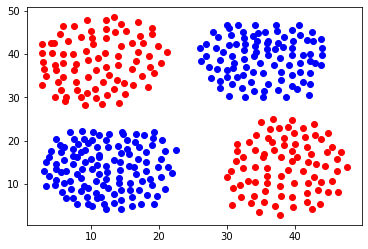

In [32]:
# get data and pray it works
data1 = sio.loadmat("pointsClass1Week6.mat")
data2 = sio.loadmat("pointsClass2Week6.mat")

data1 = data1["pointsClass1Week6"]
data2 = data2["pointsClass2Week6"]

# plot data
plt.scatter(data1[:,0], data1[:,1], c='r')
plt.scatter(data2[:,0], data2[:,1], c='b')
plt.show()

In [40]:
# targets vector
target1 = np.ones((np.shape(data1)[0], 1))
target2 = -np.ones((np.shape(data2)[0],1))

targets = np.vstack((target1, target2))

# vector containing all data points
data = np.vstack((data1, data2))


# design network 
shape = np.array([2, 20, 20, 1])
W = np.random.normal(0, 0.5, 501)

# train network
for i in range(10):
    W = binaryCrossEntropy(data, targets, W, 0.1, shape)

In [41]:
def prediction(X, W, networkSize):
    predict = np.zeros(len(X))
    for index in range(len(X)):
        x = X[index].reshape(-1, 1)
        # define important vallues
        previousLayer = x
        currLayer = 1
        preactivation = np.zeros((1, sum(networkSize[1:]))).T
        postactivation = np.zeros((1, sum(networkSize[1:]))).T
        startIndexW = 0
        endIndexW = startIndexW + (len(previousLayer) + 1) * networkSize[currLayer] # non-inclusive
        # networkSize[previousLayer] + 1     # number of neurons in current layer plus 1 for the bias
        # networkSize[currLayer + 1]     # each connecting to n nuerons in the next layer 
        startIndexA = 0
        endIndexA = networkSize[currLayer]


        # front propagation
        # calculate the initial (layer 0)   
        # grab relevant weights   
        currWeights = W[startIndexW : endIndexW]
        currWeights = np.reshape(currWeights, (networkSize[currLayer], len(previousLayer) + 1))

        # compute preactivation
        xTilde = np.vstack((1, x))
        preactivation[startIndexA : endIndexA, :] = np.matmul(currWeights, xTilde)
        postactivation[startIndexA : endIndexA, :] = sigmoid(preactivation[startIndexA : endIndexA, :])[0]

        # loop through hidden layers
        for i in range(len(networkSize) - 2):
            # update values for next run
            previousLayer = currLayer # now an index
            currLayer += 1
            startIndexW = endIndexW
            endIndexW += (networkSize[previousLayer] + 1) * networkSize[currLayer]
            startIndexA = endIndexA
            endIndexA += networkSize[currLayer]

            # grab relevant weights   
            currWeights = W[startIndexW : endIndexW]
            currWeights = np.reshape(currWeights, (networkSize[currLayer], networkSize[previousLayer] + 1))

            # compute preactivation
            # grab postactivations of previous for xTilde
            tmp = postactivation[startIndexA - networkSize[previousLayer]: startIndexA, :]
            xTilde = np.vstack((np.ones((1, len(tmp[0, :]))), tmp))
            preactivation[startIndexA : endIndexA, :] = np.matmul(currWeights, xTilde)
            postactivation[startIndexA : endIndexA, :] = sigmoid(preactivation[startIndexA : endIndexA, :])[0]
            
        predict[index] = (postactivation[-1, :] > 0.5) * 2 - 1
    return predict

In [44]:
prediction(data, W, shape).reshape(-1, 1)
# targets

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
      